# Intro to RDDS #

In this lab, we will introduce RDDs and Spark's core operations. Along the way, we'll get familiar with pyspark, notebooks, and the SparkContext.

Let's start by making sure we have a valid SparkContext.

In [32]:
sc

You should see something like: `<pyspark.context.SparkContext at 0x1015a2690>`

Now let's load some data. [SOWPODS](https://www.wordgamedictionary.com/sowpods/) is the Official Scrabble Dictionary. It contains every valid word for competitive Scrabble tournaments.

In [33]:
my_rdd = sc.textFile('./data/SOWPODS.txt')
my_rdd

./data/SOWPODS.txt MapPartitionsRDD[56] at textFile at NativeMethodAccessorImpl.java:0

You should see something like : `./data/SOWPODS.txt MapPartitionsRDD[20] at textFile at NativeMethodAccessorImpl.java:0`

Because RDDs use [lazy loading](http://spark.apache.org/docs/latest/programming-guide.html#rdd-operations), we can't actually see what's inside my_rdd yet.

To see contents, we need to execute a command with a data sink: `top`.

`top(n)` grabs the first `n` results from a Spark RDD and returns them as a regular python list.

In [34]:
my_rdd.top(20)

[u'zzzs',
 u'zzz',
 u'zyzzyvas',
 u'zyzzyva',
 u'zythums',
 u'zythum',
 u'zymurgy',
 u'zymurgies',
 u'zymotics',
 u'zymotically',
 u'zymotic',
 u'zymotechnics',
 u'zymotechnical',
 u'zymotechnic',
 u'zymosis',
 u'zymosimeters',
 u'zymosimeter',
 u'zymoses',
 u'zymosans',
 u'zymosan']

## Basic RDD operations ##

Let's start applying some basic [RDD operations](http://spark.apache.org/docs/latest/programming-guide.html#rdd-operations) to the list: filter and collect.

Note the syntax change. Those line-ending backslashes are a bit of a a pain, but the stacked syntax is very good for readability. Readability matters.

In [35]:
x_words = my_rdd \
    .filter(lambda word: len(word)>0) \
    .filter(lambda word: word[0] == 'x') \
    .collect()

Like `top`, `collect` returns a regular python list. Unlike `top`, `collect` returns *all* the results.

We can use normal python list syntax to inspect the x_words list.

In [36]:
len(x_words)

303

In [37]:
x_words[:20]

[u'xantham',
 u'xanthams',
 u'xanthan',
 u'xanthans',
 u'xanthate',
 u'xanthates',
 u'xanthation',
 u'xanthations',
 u'xanthein',
 u'xantheins',
 u'xanthene',
 u'xanthenes',
 u'xanthic',
 u'xanthin',
 u'xanthine',
 u'xanthines',
 u'xanthins',
 u'xanthism',
 u'xanthisms',
 u'xanthochroia']

## Hello, map reduce! ##

Now let's run the classic "hello world" script for distributed processing: wordcount.

In the scrabble dictionary, wordCount is boring: every word occurs once. So instead, let's do letterCount.

Let's start by using just `x_words`. We can use `parallelize` to convert a python list into a Spark RDD.

In [7]:
x_word_rdd = sc.parallelize(x_words)
x_word_rdd

ParallelCollectionRDD[4] at parallelize at PythonRDD.scala:475

Here's letter count, in pyspark:

In [38]:
letter_count_list = x_word_rdd \
    .flatMap(list) \
    .map(lambda x: (x,1)) \
    .reduceByKey(lambda x, y: x+y) \
    .collect()

letter_count_list

[(u'a', 213),
 (u'c', 63),
 (u'e', 270),
 (u'g', 59),
 (u'i', 194),
 (u'm', 82),
 (u'o', 306),
 (u's', 214),
 (u'u', 39),
 (u'y', 127),
 (u'b', 18),
 (u'd', 31),
 (u'f', 4),
 (u'h', 169),
 (u'l', 146),
 (u'n', 201),
 (u'p', 122),
 (u'r', 168),
 (u't', 141),
 (u'x', 309)]

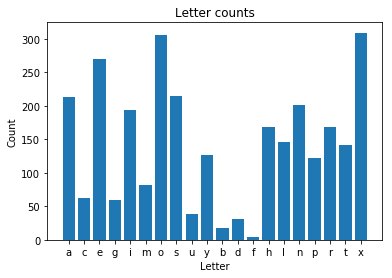

In [39]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def graph_letter_counts(letter_counts):
    x, y = zip(*letter_counts)
    fig, ax = plt.subplots()
    ax.set_xticklabels(x)
    ax.set_xticks(range(len(x)))
    plt.bar(range(len(x)), y)
    plt.title("Letter counts")
    plt.xlabel("Letter")
    plt.ylabel("Count")
    
graph_letter_counts(letter_count_list)

Nice, but it'd be better sorted. Let's sort it two ways. First, alphabetically. Second, by total count.

Let's make our code DRY by factoring out the counting part of the RDD.

In [40]:
letter_counts = x_word_rdd \
    .flatMap(list) \
    .map(lambda x: (x,1)) \
    .reduceByKey(lambda x, y: x+y)

Now sort by letter...

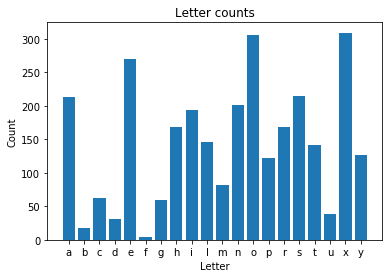

In [41]:
letter_count_list = letter_counts \
    .sortByKey() \
    .collect()

graph_letter_counts(letter_count_list)

Now sort by value...

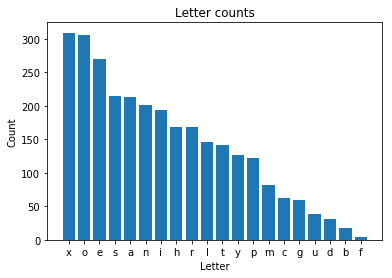

In [42]:
letter_count_list = letter_counts \
    .map(lambda (a,b): (b, a)) \
    .sortByKey(ascending=False) \
    .map(lambda (a,b): (b, a)) \
    .collect()

graph_letter_counts(letter_count_list)

## Blending python and RDDs ##

One of the huge advantages of pyspark is that you get the strengths of *both* languages.

Let's blend python and spark to identify palindromes.

In [43]:
def is_palindrome(my_str):
    return my_str == my_str[::-1]

assert is_palindrome("")
assert is_palindrome("a")
assert is_palindrome("AA")
assert is_palindrome("ABA")
assert is_palindrome("amanaplanacanalpanama")
assert is_palindrome("AB") == False
assert is_palindrome("ABC") == False

Now we plug our native python function into an RDD-based computation graph.

In [44]:
palindromes = my_rdd \
    .filter(lambda x: len(x)>0) \
    .filter(is_palindrome) \
    
palindromes.collect()

[u'aa',
 u'aba',
 u'abba',
 u'acca',
 u'aga',
 u'aha',
 u'aia',
 u'aka',
 u'ala',
 u'alula',
 u'ama',
 u'ana',
 u'anana',
 u'anna',
 u'araara',
 u'ataata',
 u'aua',
 u'ava',
 u'awa',
 u'bib',
 u'bob',
 u'boob',
 u'bub',
 u'civic',
 u'dad',
 u'deed',
 u'degged',
 u'deified',
 u'deked',
 u'deled',
 u'denned',
 u'dered',
 u'dewed',
 u'did',
 u'dod',
 u'dud',
 u'ecce',
 u'ee',
 u'eke',
 u'eme',
 u'ene',
 u'ere',
 u'esse',
 u'eve',
 u'ewe',
 u'eye',
 u'gag',
 u'gig',
 u'goog',
 u'hadedah',
 u'hah',
 u'hajjah',
 u'halalah',
 u'hallah',
 u'heh',
 u'hoh',
 u'huh',
 u'iwi',
 u'kaiak',
 u'kak',
 u'kayak',
 u'keek',
 u'kook',
 u'lemel',
 u'level',
 u'madam',
 u'malam',
 u'mallam',
 u'mam',
 u'marram',
 u'mem',
 u'mim',
 u'minim',
 u'mm',
 u'mom',
 u'mum',
 u'naan',
 u'nan',
 u'non',
 u'noon',
 u'nun',
 u'obo',
 u'oho',
 u'ono',
 u'oo',
 u'oppo',
 u'otto',
 u'oxo',
 u'pap',
 u'peep',
 u'pep',
 u'pip',
 u'poop',
 u'pop',
 u'pullup',
 u'pup',
 u'radar',
 u'redder',
 u'refer',
 u'reifier',
 u'repaper

Just for fun, let's count letters again.

In [45]:
palindrome_letter_counts = palindromes \
    .flatMap(list) \
    .map(lambda x: (x,1)) \
    .reduceByKey(lambda x, y: x+y)
    
palindrome_letter_counts \
    .sortByKey() \
    .collect()

[(u'a', 91),
 (u'b', 12),
 (u'c', 8),
 (u'd', 31),
 (u'e', 87),
 (u'f', 3),
 (u'g', 10),
 (u'h', 20),
 (u'i', 29),
 (u'j', 2),
 (u'k', 13),
 (u'l', 25),
 (u'm', 31),
 (u'n', 21),
 (u'o', 46),
 (u'p', 20),
 (u'r', 33),
 (u's', 57),
 (u't', 39),
 (u'u', 25),
 (u'v', 9),
 (u'w', 8),
 (u'x', 2),
 (u'y', 4),
 (u'z', 7)]

## A grab-bag of operators and actions ##

Here are some other useful pyspark actions you can use. Most of these are `actions`, meaning that they complete an RDD calculation chain and return some other kind of object.


In [46]:
palindrome_letter_counts.first()

(u'a', 91)

In [47]:
palindrome_letter_counts.take(10)

[(u'a', 91),
 (u'c', 8),
 (u'e', 87),
 (u'g', 10),
 (u'i', 29),
 (u'k', 13),
 (u'm', 31),
 (u'o', 46),
 (u's', 57),
 (u'u', 25)]

In [48]:
palindrome_letter_counts.takeOrdered(10, lambda x: x[1])

[(u'j', 2),
 (u'x', 2),
 (u'f', 3),
 (u'y', 4),
 (u'z', 7),
 (u'c', 8),
 (u'w', 8),
 (u'v', 9),
 (u'g', 10),
 (u'b', 12)]

In [49]:
palindrome_letter_counts.takeOrdered(10, lambda x: -1*x[1])

[(u'a', 91),
 (u'e', 87),
 (u's', 57),
 (u'o', 46),
 (u't', 39),
 (u'r', 33),
 (u'm', 31),
 (u'd', 31),
 (u'i', 29),
 (u'u', 25)]

In [50]:
palindrome_letter_counts.takeOrdered(10, lambda x: x[0])

[(u'a', 91),
 (u'b', 12),
 (u'c', 8),
 (u'd', 31),
 (u'e', 87),
 (u'f', 3),
 (u'g', 10),
 (u'h', 20),
 (u'i', 29),
 (u'j', 2)]

In [51]:
my_rdd.count()

267759

In [22]:
sampled_words = my_rdd \
    .sample(False, .02) \
    .collect()

print len(sampled_words)

5507


## Exercise 1 - Filters and actions ##

1. Get a sample of 5% of the SOWPODS words.
2. Find the first word that start with J.
3. Find the last 10 words that start with J.
4. How many words end with the letter E?

In [65]:
sowpods_rdd = sc.textFile('./data/SOWPODS.txt')

sampled_words = my_rdd \
    .sample(False, .05) \
    .collect()

print len(sampled_words)

x_words = my_rdd \
    .filter(lambda word: len(word)>0) \
    .filter(lambda x: x[0] in ['J','j']) \
    .takeOrdered(10, key = lambda x: -x)
    
    
    
    
print(x_words)


#Your code goes here

13232


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 106.0 failed 1 times, most recent failure: Lost task 0.0 in stage 106.0 (TID 151, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 1290, in <lambda>
    return self.mapPartitions(lambda it: [heapq.nsmallest(num, it, key)]).reduce(merge)
  File "/Users/ceoxxx/anaconda/envs/py2/lib/python2.7/heapq.py", line 432, in nsmallest
    result = _nsmallest(n, it)
  File "<ipython-input-65-d7804f1f569b>", line 7, in <lambda>
TypeError: bad operand type for unary -: 'unicode'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1958)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:934)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor69.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 1290, in <lambda>
    return self.mapPartitions(lambda it: [heapq.nsmallest(num, it, key)]).reduce(merge)
  File "/Users/ceoxxx/anaconda/envs/py2/lib/python2.7/heapq.py", line 432, in nsmallest
    result = _nsmallest(n, it)
  File "<ipython-input-65-d7804f1f569b>", line 7, in <lambda>
TypeError: bad operand type for unary -: 'unicode'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


## Exercise 2 - Counting and cleaning ##

What is the distribution of word lengths in SOWPODS? That is, how many 2-letter, 3-letter, 4-letter, etc. words does the dictionary contain?

(Note: You'll have to do a little bit of data cleaning to make this work.)

In [24]:
(sowpods_rdd
    # Your code goes here
    .collect()
)

[u'SOWPODS (Europe Scrabble Word List)',
 u'',
 u'Did you know this is a European word list? You can find the US version here http://www.wordgamedictionary.com/twl06/download/twl06.txt',
 u'',
 u'You can also find an extensive and larger English word list here http://www.wordgamedictionary.com/english-word-list/download/english.txt',
 u'',
 u'aa',
 u'aah',
 u'aahed',
 u'aahing',
 u'aahs',
 u'aal',
 u'aalii',
 u'aaliis',
 u'aals',
 u'aardvark',
 u'aardvarks',
 u'aardwolf',
 u'aardwolves',
 u'aargh',
 u'aarrgh',
 u'aarrghh',
 u'aarti',
 u'aartis',
 u'aas',
 u'aasvogel',
 u'aasvogels',
 u'ab',
 u'aba',
 u'abac',
 u'abaca',
 u'abacas',
 u'abaci',
 u'aback',
 u'abacs',
 u'abacterial',
 u'abactinal',
 u'abactinally',
 u'abactor',
 u'abactors',
 u'abacus',
 u'abacuses',
 u'abaft',
 u'abaka',
 u'abakas',
 u'abalone',
 u'abalones',
 u'abamp',
 u'abampere',
 u'abamperes',
 u'abamps',
 u'aband',
 u'abanded',
 u'abanding',
 u'abandon',
 u'abandoned',
 u'abandonedly',
 u'abandonee',
 u'abandonees',

### Exercise 3 - Lazy execution ###

Check out this function. It works for string numbers and breaks for other characters:

In [25]:
def parse_int(my_char):
    return int(my_char)

print parse_int("5")
print parse_int("g")

5


ValueError: invalid literal for int() with base 10: 'g'

Why does this work?

In [26]:
my_list = list('0123456789a')
my_rdd = sc.parallelize(my_list)

my_rdd.map(parse_int).take(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

...this fail?

In [27]:
my_rdd.map(parse_int).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 41.0 failed 1 times, most recent failure: Lost task 1.0 in stage 41.0 (TID 55, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "<ipython-input-25-3ee3a41425fa>", line 2, in parse_int
ValueError: invalid literal for int() with base 10: 'a'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:156)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:152)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:935)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1958)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:934)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor69.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "<ipython-input-25-3ee3a41425fa>", line 2, in parse_int
ValueError: invalid literal for int() with base 10: 'a'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:156)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:152)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:935)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


...and this *sometimes* fail?

In [28]:
my_rdd.sample(False, .5).map(parse_int).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 42.0 failed 1 times, most recent failure: Lost task 1.0 in stage 42.0 (TID 57, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "<ipython-input-25-3ee3a41425fa>", line 2, in parse_int
ValueError: invalid literal for int() with base 10: 'a'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:156)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:152)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:935)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1958)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:934)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor69.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/ceoxxx/spark/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 268, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "<ipython-input-25-3ee3a41425fa>", line 2, in parse_int
ValueError: invalid literal for int() with base 10: 'a'

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:156)
	at org.apache.spark.api.python.PythonRunner$$anon$1.next(PythonRDD.scala:152)
	at org.apache.spark.InterruptibleIterator.next(InterruptibleIterator.scala:43)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:935)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:1944)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


## Bonus Exercise ##

Let's up the stakes. For this exercise, regular expressions are *not allowed.*
- How many SOWPODS words contain double 'aa's?
- How about 'bb', 'cc', 'dd', ..., 'zz'?
- There are 3 SOWPODS words that contain triple letters. What are they?